## Import functions

In [255]:
#https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [279]:
import pandas as  pd
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import sklearn

import warnings
warnings.filterwarnings('ignore')

In [280]:
print("mlflow =",mlflow.__version__)
print("numpy =",np.__version__)
print("pandas =",pd.__version__)
print("sklearn =",sklearn.__version__)

mlflow = 2.3.2
numpy = 1.24.3
pandas = 2.0.2
sklearn = 1.2.2


## Import local functions

In [281]:
from utils.preprocessing import read, prepare

In [282]:
target = 'median_house_value'
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
categorical = ['ocean_proximity']

# Setup  MLflow

run local:
```
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlflow/artifacts --host 0.0.0.0 -p 4600
```

run production:
```
run mlflow server --backend-store-uri postgresql://{USER_NAME}:{PASSWORD}@{HOST}:5432/{DATABASE_NAME} --default-artifact-root s3://{S3_BUCKET_NAME} -p 5000 -h 0.0.0.0
```

In [295]:
from dotenv import load_dotenv
import os

load_dotenv()

TRACKING_URI = os.getenv("TRACKING_URI")
EXPERIMENT_NAME = "california_housing_collaborative"

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()

2023/05/31 23:29:14 INFO mlflow.tracking.fluent: Experiment with name 'california_housing_production' does not exist. Creating a new experiment.


# Optimization function

In [297]:
from numpy.typing import ArrayLike
from utils.model_io import load_pickle

def compare_predictions(y_values: ArrayLike, y_prediction: ArrayLike) -> plt.Figure:
    fig, axs = plt.subplots()
    sns.distplot(y_prediction, label='Prediction')
    sns.distplot(y_values, label='Actual')
    plt.legend()
    plt.title('Comparison of Predicted Values and Actual Values')
    plt.xlabel('Values')
    plt.ylabel('Density')
    return fig

def run(df_train: pd.DataFrame, df_test: pd.DataFrame, num_trials=100):
    
    X_train = df_train.drop(columns=target)
    X_test = df_test.drop(columns=target)

    y_train = df_train[target].values
    y_test = df_test[target].values

    best_loss = float('inf')
    best_y_pred = None

    def objective(params):
        nonlocal best_loss, best_y_pred
        
        with mlflow.start_run():
            
            # Define customer tag
            tags = {"Application": "California Housing Prices Prediction",
                    "user": "Juan",
                    "release.version": "1.1.0"}

            # Set Tag
            mlflow.set_tags(tags)
            
            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            
            y_pred_test = rf.predict(X_test)
            y_pred_train = rf.predict(X_train)
            
            val_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
            test_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            
            fig = compare_predictions(y_test, y_pred_test) 
            mlflow.log_figure(fig, 'Comparison of Predicted Values and Actual Values.png')
            
            
            mlflow.log_artifact('./data/preprocess/dv.pkl', artifact_path='dv.pkl')
            mlflow.log_artifact('./data/preprocess/scaler.pkl', artifact_path='scaler.pkl')
            
            
        if val_rmse < best_loss:
            best_loss = val_rmse
            best_y_pred = y_pred_test

        return {'loss': val_rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

    return best_y_pred, y_test



# Read dataframe

In [298]:
raw_housing = read('housing.csv')
raw_housing = raw_housing[raw_housing.ocean_proximity!='ISLAND'] 
raw_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [299]:
raw_housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

* Filling null values

In [300]:
raw_housing['total_bedrooms'] = raw_housing['total_bedrooms'].fillna(raw_housing['total_bedrooms'].median())

In [301]:
raw_housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: count, dtype: int64

# Prepare our dataset

In [302]:
from sklearn.model_selection import train_test_split

raw_train, raw_test= train_test_split(raw_housing, test_size=0.3, random_state=42)

In [303]:
raw_train.shape, raw_test.shape

((14444, 10), (6191, 10))

In [304]:
prepare_train = prepare(raw_train,fit=True,data_path='data/preprocess/')
prepare_test = prepare(raw_test,fit=True,data_path='data/preprocess/')


100%|██████████| 10/10 [03:23<00:00, 20.32s/trial, best loss: 58228.989100099694]


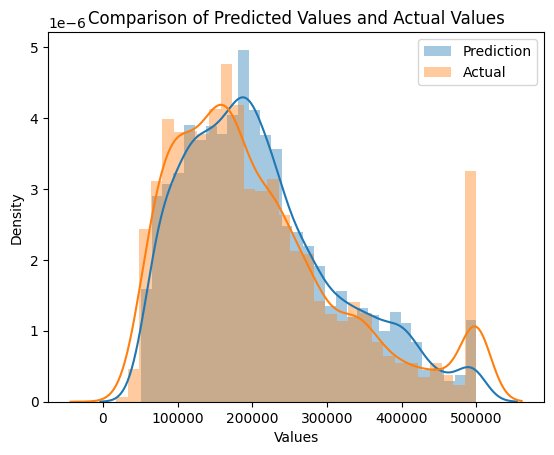

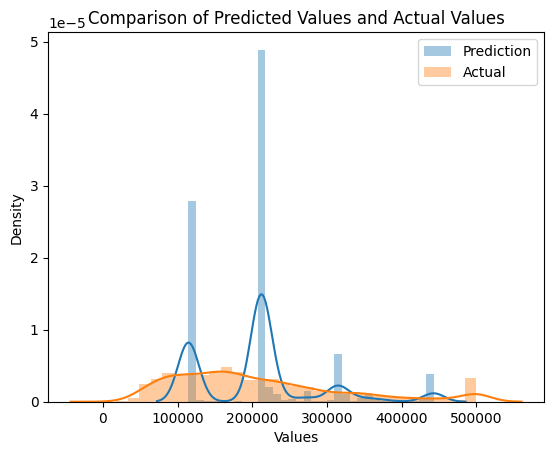

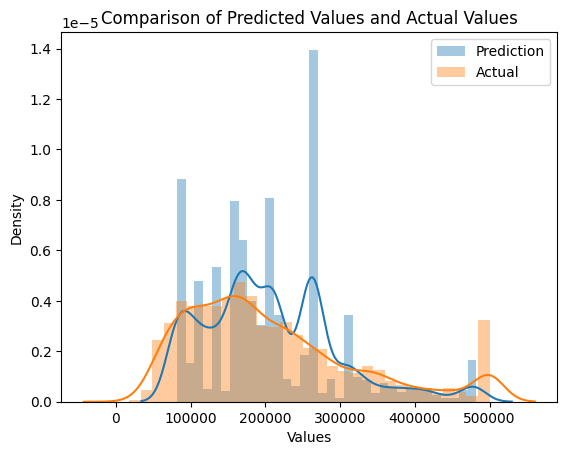

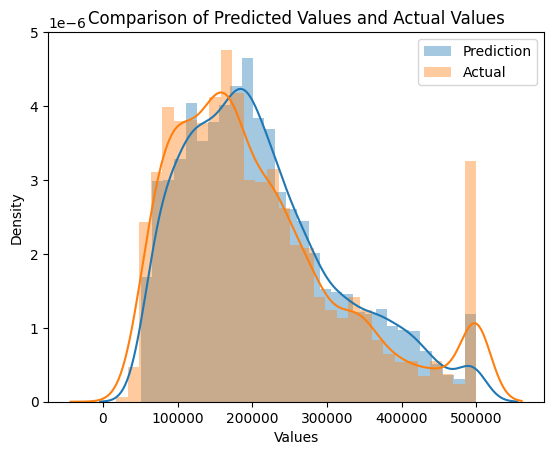

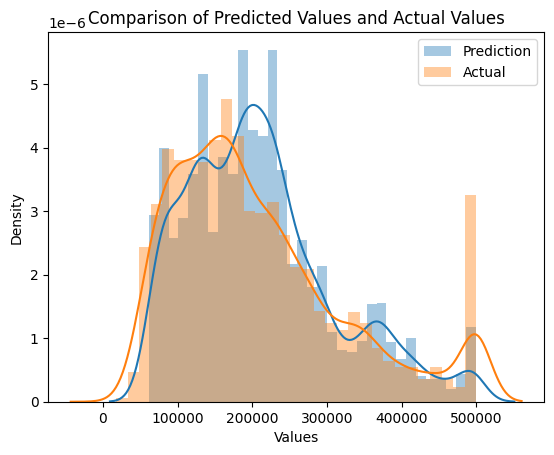

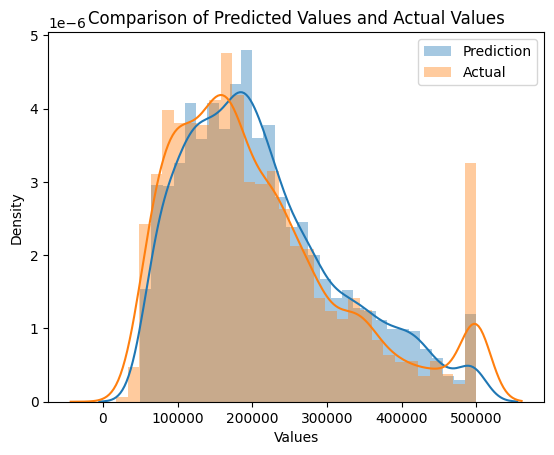

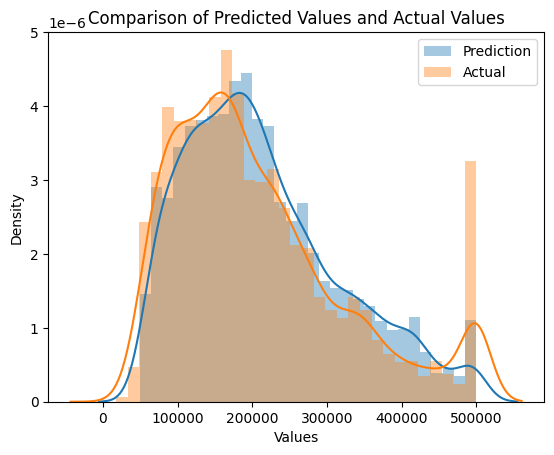

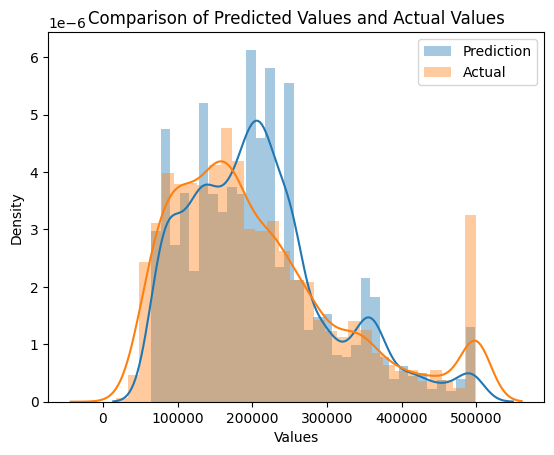

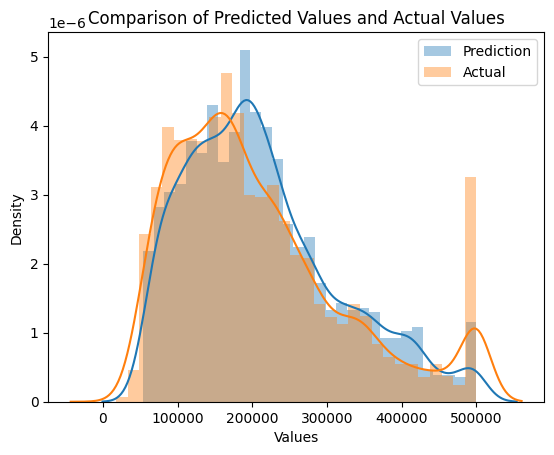

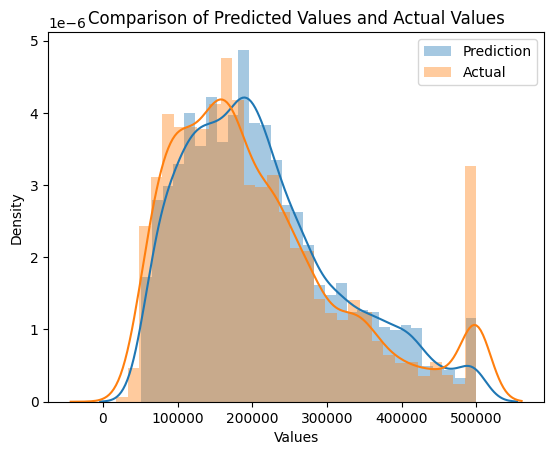

In [305]:
best_y_pred, y_test = run(prepare_train,prepare_test,10)


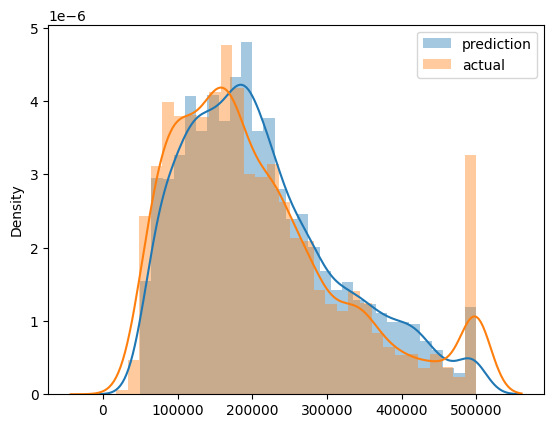

In [272]:
sns.distplot(best_y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()